# Criação de um Classificador para Tipos e Severidades de Desastres Urbanos

## Introdução e Objetivo:

Este relatório detalha o processo de desenvolvimento e otimização de modelos de Machine Learning para a classificação automática do tipo e do nível de severidade de desastres urbanos a partir de relatos textuais. O objetivo principal é criar um sistema capaz de auxiliar na triagem e priorização de alertas, direcionando recursos de forma mais eficiente em situações de emergência.

Os dados utilizados para o treinamento e avaliação dos modelos são sintéticos, gerados e validados em uma etapa anterior (conforme documentado no notebook 01_Synthetic_Data_Generation), garantindo um conjunto de dados controlado e adequado para as fases iniciais de desenvolvimento do classificador.


## Configuração Inicial

**Tecnologias Aplicadas Nesta Etapa:**

* Pandas: Para manipulação eficiente de dados (dataset em formato CSV).
* NumPy: No manuseio de arrays e matrizes.
* NLTK (Natural Language Toolkit): Para tarefas de processamento de linguagem natural, como remoção de stopwords e stemming (RSLPStemmer).
* Scikit-learn: Principal biblioteca para Machine Learning, utilizada para:
  * Vetorização de texto (TfidfVectorizer).
  * Divisão de dados (train_test_split).
  * Implementação dos algoritmos de classificação (MultinomialNB, LogisticRegression, LinearSVC).
  * Avaliação de modelos (classification_report, confusion_matrix, accuracy_score).
  * Ajuste de hiperparâmetros (GridSearchCV).
* Joblib: Para salvar e carregar os modelos treinados e vetorizadores.
* Seaborn & Matplotlib: Para a visualização de dados, como matrizes de confusão e gráficos de análise.
* SciPy: Para a manipulação de matrizes esparsas (csr_matrix, hstack).

In [ ]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import unicodedata
import joblib
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix
from collections import Counter
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
GOOGLE_DRIVE_BASE_PATH = '/content/drive/MyDrive/Colab_Notebooks'
PROJECT_FOLDER_NAME = 'AlertaVermelho_AI'
project_base_path = os.path.join(GOOGLE_DRIVE_BASE_PATH, PROJECT_FOLDER_NAME)
dataset_path = os.path.join(project_base_path, 'Datasets/alertas_sinteticos_final_v2.csv')

## Manipulando o CSV com dados sintéticos

Nessa etapa eu vou pular o processo inicial de valição e limpeza dos dados, pois foram dados que eu gerei de maneira sointética e já validei no momento da geração, resultados no notebook (01_Synthetic_Data_Generation).

Só farei as limpeza das colunas (`llm_output_tipo` e `llm_output_severidade`), pois foram utilizadas para validação manual e não tem serventia para o treinamento do classificador

In [ ]:
df_alertas = pd.read_csv(dataset_path)

In [ ]:
df_alertas.head()

,descricaoTexto,tipo_ia_label,severidade_ia_label,llm_output_tipo,llm_output_severidade
0,Deslizamento parcial na Estrada da Serra! Área...,DESLIZAMENTO_OCORRIDO,MEDIA,DESLIZAMENTO_OCORRIDO,MEDIA
1,Tem um poste inclinado na esquina da Rua das F...,OUTRO_PERIGO,MEDIA,OUTRO_PERIGO,MEDIA
2,Um poste de luz caiu perto da padaria do seu Z...,OUTRO_PERIGO,CRITICA,OUTRO_PERIGO,CRITICA
3,Um deslizamento aconteceu atrás do condomínio ...,DESLIZAMENTO_OCORRIDO,MEDIA,DESLIZAMENTO_OCORRIDO,MEDIA
4,"Na Rua das Flores, houve um pequeno deslizamen...",RISCO_DESLIZAMENTO,BAIXA,RISCO_DESLIZAMENTO,BAIXA


In [ ]:
df_copy = df_alertas.copy()
df_copy = df_copy.drop(columns=['llm_output_tipo', 'llm_output_severidade'])
df_copy.head()

,descricaoTexto,tipo_ia_label,severidade_ia_label
0,Deslizamento parcial na Estrada da Serra! Área...,DESLIZAMENTO_OCORRIDO,MEDIA
1,Tem um poste inclinado na esquina da Rua das F...,OUTRO_PERIGO,MEDIA
2,Um poste de luz caiu perto da padaria do seu Z...,OUTRO_PERIGO,CRITICA
3,Um deslizamento aconteceu atrás do condomínio ...,DESLIZAMENTO_OCORRIDO,MEDIA
4,"Na Rua das Flores, houve um pequeno deslizamen...",RISCO_DESLIZAMENTO,BAIXA


In [ ]:
tipo_unicos = pd.unique(df_copy['tipo_ia_label'])
severidade_unicos = pd.unique(df_copy['severidade_ia_label'])

print("Tipos:", tipo_unicos)
print("Severidades:", severidade_unicos)
print("Ex de relato: ",df_copy['descricaoTexto'].iloc[0])

Tipos: ['DESLIZAMENTO_OCORRIDO' 'OUTRO_PERIGO' 'RISCO_DESLIZAMENTO' 'ALAGAMENTO']
Severidades: ['MEDIA' 'CRITICA' 'BAIXA' 'ALTA']
Ex de relato:  Deslizamento parcial na Estrada da Serra! Área instável, evitem proximidade!


In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   descricaoTexto       1000 non-null   object
 1   tipo_ia_label        1000 non-null   object
 2   severidade_ia_label  1000 non-null   object
 3   lex_count_critica    1000 non-null   int64 
 4   lex_count_alta       1000 non-null   int64 
 5   lex_count_media      1000 non-null   int64 
 6   lex_count_baixa      1000 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 54.8+ KB


## Pré-processamento do texto

Crucial para a qualidade, esta etapa transforma o texto cru em um formato mais limpo e útil para o modelo.

In [ ]:
# Baixando recursos do NLTK
nltk.download('stopwords')
nltk.download('rslp') # Para o stemmer RSLP

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [ ]:
stop_words_pt = set(stopwords.words('portuguese'))
stemmer_pt = RSLPStemmer()

In [ ]:
def preprocessar_texto(texto):
  if not isinstance(texto, str):
    return ""

  # Converter para minúsculas
  texto = texto.lower()

  # Remover acentuação
  texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')

  # Remover pontuação e caracteres não alfanuméricos (manter apenas letras, números e espaços)
  texto = re.sub(r'[^a-z0-9\s]', '', texto)

  # Remover múltiplos espaços
  texto = re.sub(r'\s+', ' ', texto).strip()

  # Tokenização
  tokens = texto.split()

  # Remover stopwords e aplicar stemming
  tokens_processados = [stemmer_pt.stem(palavra) for palavra in tokens if palavra not in stop_words_pt]

  return " ".join(tokens_processados)

In [ ]:
df_copy['descricaoTexto'] = df_copy['descricaoTexto'].apply(preprocessar_texto)
X_processado = df_copy['descricaoTexto']

Importante mencionar de apesar de parecer que a palavra está com a grafia incorreta esse é um processo necessário de vector search onde ocorre a decomposição das palavras para seus radicias mais primários

In [ ]:
X_processado.head()

,descricaoTexto
0,desliz parc estr serr are insta evit proxim
1,post inclin esquin rua fl parec pod cair qualq...
2,post luz caiu pert pad ze solt faisc evit pass...
3,desliz acontec atr condomini feliz obstru part...
4,rua fl pequen desliz terr situaca sob control ...


In [ ]:
# Inicializar o vetorizador TF-IDF
vetorizador_tfidf = TfidfVectorizer(
    ngram_range=(1, 2), # Considera palavras isoladas e sequências de duas palavras (bigramas)
    max_df=0.95,        # Ignora termos que aparecem em mais de 95% dos documentos
    min_df=2,           # Ignora termos que aparecem em menos de 2 documentos
    sublinear_tf=True   # Aplica scaling logarítmico na frequência do termo
)

X_tfidf = vetorizador_tfidf.fit_transform(X_processado)

In [ ]:
joblib.dump(vetorizador_tfidf, 'vetorizador_tfidf.pkl')

['vetorizador_tfidf.pkl']

## Train / Test split

In [ ]:
X_texto = df_copy['descricaoTexto']
y_tipo = df_copy['tipo_ia_label']
y_severidade = df_copy['severidade_ia_label']

print("Amostra de y_tipo:", y_tipo.head())
print("Amostra de y_severidade:", y_severidade.head())

Amostra de y_tipo: 0    DESLIZAMENTO_OCORRIDO
1             OUTRO_PERIGO
2             OUTRO_PERIGO
3    DESLIZAMENTO_OCORRIDO
4       RISCO_DESLIZAMENTO
Name: tipo_ia_label, dtype: object
Amostra de y_severidade: 0      MEDIA
1      MEDIA
2    CRITICA
3      MEDIA
4      BAIXA
Name: severidade_ia_label, dtype: object


In [ ]:
X_processado = df_copy['descricaoTexto']
X_tfidf = vetorizador_tfidf.fit_transform(X_processado)

In [ ]:
# Para o modelo de TIPO
X_treino_tipo, X_teste_tipo, y_treino_tipo, y_teste_tipo = train_test_split(
  X_tfidf, y_tipo, test_size=0.25, random_state=42, stratify=y_tipo
)

# Para o modelo de SEVERIDADE
X_treino_sev, X_teste_sev, y_treino_sev, y_teste_sev = train_test_split(
  X_tfidf, y_severidade, test_size=0.25, random_state=42, stratify=y_severidade
)

## Treinamento

### Treinamento do modelo de TIPO

In [ ]:
# Tipo 1: Naive Bayes
modelo_nb_tipo = MultinomialNB()
modelo_nb_tipo.fit(X_treino_tipo, y_treino_tipo)
pred_nb_tipo = modelo_nb_tipo.predict(X_teste_tipo)
print("Resultados Naive Bayes (Tipo):")
print(classification_report(y_teste_tipo, pred_nb_tipo))

Resultados Naive Bayes (Tipo):
                       precision    recall  f1-score   support

           ALAGAMENTO       0.90      1.00      0.95        99
DESLIZAMENTO_OCORRIDO       0.97      0.83      0.90        47
         OUTRO_PERIGO       1.00      0.69      0.82        39
   RISCO_DESLIZAMENTO       0.88      0.98      0.93        65

             accuracy                           0.92       250
            macro avg       0.94      0.88      0.90       250
         weighted avg       0.92      0.92      0.91       250



 O Naive Bayes teve um desempenho muito bom, com uma acurácia de 0.92 e F1-score ponderado de 0.91. Ele teve um  recall de 100% para ALAGAMENTO e 98% para RISCO_DESLIZAMENTO, significando que identifica corretamente quase todos os casos dessas categorias. A precisão também é alta para a maioria das classes, especialmente para OUTRO_PERIGO (1.00), o que significa que quando ele prevê "Outro Perigo", ele está correto. No entanto, o recall para OUTRO_PERIGO (0.69) é o mais baixo entre as classes, sugerindo que o modelo deixa de identificar cerca de 31% dos casos que realmente pertencem a esta categoria

In [ ]:
# Tipo 2: Logistic Regression
modelo_lr_tipo = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr', max_iter=1000)
modelo_lr_tipo.fit(X_treino_tipo, y_treino_tipo)
pred_lr_tipo = modelo_lr_tipo.predict(X_teste_tipo)
print("\nResultados Logistic Regression (Tipo):")
print(classification_report(y_teste_tipo, pred_lr_tipo))


Resultados Logistic Regression (Tipo):
                       precision    recall  f1-score   support

           ALAGAMENTO       0.93      1.00      0.97        99
DESLIZAMENTO_OCORRIDO       1.00      0.91      0.96        47
         OUTRO_PERIGO       1.00      0.85      0.92        39
   RISCO_DESLIZAMENTO       0.94      0.98      0.96        65

             accuracy                           0.96       250
            macro avg       0.97      0.94      0.95       250
         weighted avg       0.96      0.96      0.96       250



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


A logistic regression também teve um desempenho excelente, com uma acurácia de 0.96 e um F1-score ponderado de 0.96. Este modelo é bem equilibrado entre precisão e recall para todas as classes com um recall muito alto para todas. Isso indica que o modelo não só é muito preciso em suas classificações, mas também consegue identificar corretamente a grande maioria dos casos de cada tipo de desastre.



In [ ]:
# Tipo 3: LinearSVC
modelo_svc_tipo = LinearSVC(random_state=42, dual=True, max_iter=1000)
modelo_svc_tipo.fit(X_treino_tipo, y_treino_tipo)
pred_svc_tipo = modelo_svc_tipo.predict(X_teste_tipo)
print("\nResultados LinearSVC (Tipo):")
print(classification_report(y_teste_tipo, pred_svc_tipo))


Resultados LinearSVC (Tipo):
                       precision    recall  f1-score   support

           ALAGAMENTO       0.97      1.00      0.99        99
DESLIZAMENTO_OCORRIDO       1.00      0.96      0.98        47
         OUTRO_PERIGO       1.00      0.92      0.96        39
   RISCO_DESLIZAMENTO       0.96      0.98      0.97        65

             accuracy                           0.98       250
            macro avg       0.98      0.97      0.97       250
         weighted avg       0.98      0.98      0.98       250



Já o LinearSVC se destacou consideravelmente, com uma acurácia de 0.98 e um F1-score ponderado de 0.98, ele chega quase na perfeição. Todas as classes apresentam F1-scores altíssimos (entre 0.96 e 0.99). Com o recall para OUTRO_PERIGO atinge 0.92 com precisão de 1.00, mostrando que o modelo é extremamente eficaz em identificar corretamente e com segurança todos os tipos de perigo, incluindo aqueles que são mais diversos ou menos frequentes

Concluindo, tivemos um excelente resultado na classificação do tipo de desastre para todos os modelos mas especialmente com o LinearSVC. Isso indica que as features extraídas pelo TF-IDF e o pré-processamento foram bastante eficazes para a calssificação do tipo de desastre.

Para a próxima etapa (hyperparameter tuning): não vejo necessidade, para o modelo de TIPO já que os ganhos seriam mínimos

### Treinamento do modelo de SEVERIDADE

In [ ]:
# Tipo 1: Naive Bayes
modelo_nb_sev = MultinomialNB()
modelo_nb_sev.fit(X_treino_sev, y_treino_sev)
pred_nb_sev = modelo_nb_sev.predict(X_teste_sev)
print("Resultados Naive Bayes (Severidade):")
print(classification_report(y_teste_sev, pred_nb_sev))

Resultados Naive Bayes (Severidade):
              precision    recall  f1-score   support

        ALTA       0.69      0.74      0.71        69
       BAIXA       1.00      0.27      0.42        49
     CRITICA       0.95      0.74      0.83        50
       MEDIA       0.57      0.87      0.69        82

    accuracy                           0.69       250
   macro avg       0.80      0.65      0.66       250
weighted avg       0.76      0.69      0.67       250



 Teve uma acurácia de 0.69 e um F1-score ponderado de 0.67 para a tarefa de classificar a severidade. O desempenho variou muito entre as classes. Enquanto ele teve alta precisão para BAIXA (1.00) e CRITICA (0.95), o recall para a classe BAIXA é muito baixo (0.27). Por outro lado, para MEDIA, o recall é alto (0.87), mas a precisão é mais baixa (0.57), o que indica que ele identifica bem os casos de severidade média, mas também classifica errado outras severidades como MEDIA

In [ ]:
# Tipo 2: Logistic Regression
modelo_lr_sev = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr', max_iter=1000)
modelo_lr_sev.fit(X_treino_sev, y_treino_sev)
pred_lr_sev = modelo_lr_sev.predict(X_teste_sev)
print("\nResultados Logistic Regression (Severidade):")
print(classification_report(y_teste_sev, pred_lr_sev))


Resultados Logistic Regression (Severidade):
              precision    recall  f1-score   support

        ALTA       0.73      0.77      0.75        69
       BAIXA       0.83      0.51      0.63        49
     CRITICA       0.90      0.76      0.83        50
       MEDIA       0.65      0.83      0.73        82

    accuracy                           0.74       250
   macro avg       0.78      0.72      0.73       250
weighted avg       0.76      0.74      0.73       250



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Já a Regressão Logística apresenta um desempenho geral superior ao Naive Bayes, com uma acurácia de 0.74 e um F1-score ponderado de 0.73, é um modelo balanceado entre as classes. A classe BAIXA teve uma melhora substancial no recall (de 0.27 para 0.51) em comparação com o Naive Bayes, embora ainda seja a classe com o menor F1-score. CRITICA mantém um F1-score ótimo de 0.83, e ALTA e MEDIA também mostram bons F1-scores (0.75 e 0.73)

In [ ]:
# Tipo 3: LinearSVC
modelo_svc_sev = LinearSVC(random_state=42, dual=True, max_iter=1000)
modelo_svc_sev.fit(X_treino_sev, y_treino_sev)
pred_svc_sev = modelo_svc_sev.predict(X_teste_sev)
print("\nResultados LinearSVC (Severidade):")
print(classification_report(y_teste_sev, pred_svc_sev))


Resultados LinearSVC (Severidade):
              precision    recall  f1-score   support

        ALTA       0.74      0.80      0.77        69
       BAIXA       0.84      0.65      0.74        49
     CRITICA       0.89      0.84      0.87        50
       MEDIA       0.71      0.79      0.75        82

    accuracy                           0.78       250
   macro avg       0.80      0.77      0.78       250
weighted avg       0.78      0.78      0.78       250



Linear SVC apresentou uma leve vantagem com relação aos outros, com o melhor desempenho para a classificação de severidade, alcançando uma acurácia de 0.78 e um F1-score ponderado de 0.78. Todas as classes apresentam F1-scores acima de 0.74, com CRITICA chegando a um impressionante 0.87. O modelo aparentemente tem um bom equilíbrio entre precisão e recall para todas as categorias

Antes de passar para a próxima etapa no modelo de severidade, vamos pergar o modelo de Linear SVC e tentar ajustar:

Justificativa: Embora todos os modelos tenham tido desempenho mediano (se tratando da prevenção de desastres), o LinearSVC apresentou uma vantagem geral nas métricas. O ganho com hyperparameter tuning pode acabar sendo irrelevante se o problema principal for a qualidade/natureza das features, vamos tentar entender o que acontece.

In [ ]:
nomes_classes_severidade = sorted(list(df_copy['severidade_ia_label'].unique()))

In [ ]:
cm_sev = confusion_matrix(y_teste_sev, pred_svc_sev, labels=nomes_classes_severidade)
print("Matriz de Confusão (LinearSVC - Severidade):")
print(cm_sev)
print("\nRelatório de Classificação (LinearSVC - Severidade):")
print(classification_report(y_teste_sev, pred_svc_sev, target_names=nomes_classes_severidade))

Matriz de Confusão (LinearSVC - Severidade):
[[55  0  5  9]
 [ 1 32  0 16]
 [ 7  0 42  1]
 [11  6  0 65]]

Relatório de Classificação (LinearSVC - Severidade):
              precision    recall  f1-score   support

        ALTA       0.74      0.80      0.77        69
       BAIXA       0.84      0.65      0.74        49
     CRITICA       0.89      0.84      0.87        50
       MEDIA       0.71      0.79      0.75        82

    accuracy                           0.78       250
   macro avg       0.80      0.77      0.78       250
weighted avg       0.78      0.78      0.78       250



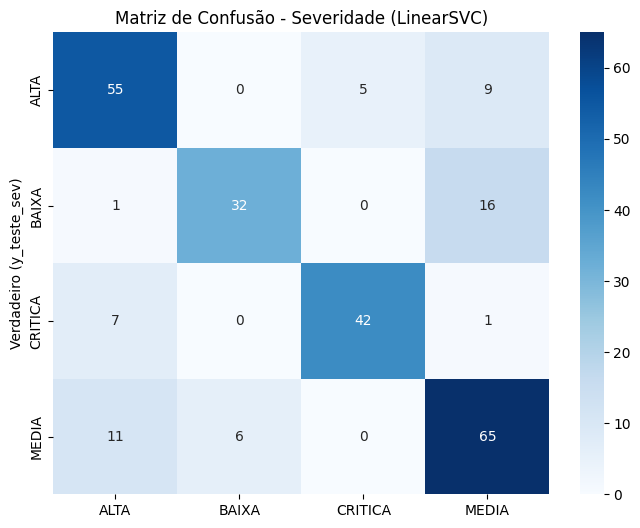

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_sev, annot=True, fmt='d', cmap='Blues', xticklabels=nomes_classes_severidade, yticklabels=nomes_classes_severidade)
plt.ylabel('Verdadeiro (y_teste_sev)')
plt.title('Matriz de Confusão - Severidade (LinearSVC)')
plt.show()

* BAIXA x MEDIA: A maior confusão é de relatos BAIXA sendo classificados como MEDIA (16 casos). Isso sugere que o modelo tem dificuldade em traçar uma linha clara entre esses dois níveis de severidade menos sérias, tendendo a classificar relatos BAIXA como um pouco mais sérios

* Confusão entre ALTA x MEDIA e MEDIA x BAIXA: MEDIA é confundida com ALTA (9 vezes), e MEDIA com BAIXA (6 vezes). O modelo provavelmente esta usando a MÉDIA como fallback, uma categoria padrão quando ele fica na dúvida

* E isso acaba levando a classe MEDIA a ter vários erros de predição quando a classe real é ALTA ou BAIXA. Além disso, há uma pequena troca de classificação entre ALTA e CRITICA, indicando que a diferença entre esses níveis mais elevados ainda precisa ser mais bem definida

In [ ]:
categorias_severidade = df_copy['severidade_ia_label'].unique()
frequencia_por_categoria = {}

A primeira coisa que vamos fazer é ver a frequência dos radicais (stems) dentro de cada categoria de severidade pra verificar se tem palavras chave que se repetem pra cada categoria e ajudar a orientar os dados

In [ ]:
for categoria in categorias_severidade:
  print(f"\nAnalisando Categoria: {categoria}")

  textos_da_categoria = df_copy[df_copy['severidade_ia_label'] == categoria]['descricaoTexto']

  todos_radicais_da_categoria = []
  for texto in textos_da_categoria:
    if isinstance(texto, str):
      todos_radicais_da_categoria.extend(texto.split())

  if todos_radicais_da_categoria:
    contador_radicais = Counter(todos_radicais_da_categoria)
    frequencia_por_categoria[categoria] = contador_radicais

    n_mais_comuns = 30
    print(f"Os {n_mais_comuns} radicais mais comuns para a categoria '{categoria}':")
    for radical, contagem in contador_radicais.most_common(n_mais_comuns):
      print(f"  - '{radical}': {contagem} vezes")
  else:
    print(f"Nenhum radical encontrado para a categoria '{categoria}' (textos podem estar vazios ou não ser strings).")


Analisando Categoria: MEDIA
Os 30 radicais mais comuns para a categoria 'MEDIA':
  - 'rua': 197 vezes
  - 'agu': 135 vezes
  - 'prox': 119 vezes
  - 'desliz': 114 vezes
  - 'evit': 112 vezes
  - 'atenca': 108 vezes
  - 'numer': 103 vezes
  - 'are': 101 vezes
  - 'acumul': 101 vezes
  - 'aven': 97 vezes
  - 'fl': 95 vezes
  - 'risc': 79 vezes
  - 'transit': 76 vezes
  - 'chuv': 74 vezes
  - 'situaca': 74 vezes
  - 'ha': 73 vezes
  - 'moder': 72 vezes
  - 'encost': 62 vezes
  - 'atent': 61 vezes
  - 'alag': 57 vezes
  - 'cuid': 56 vezes
  - 'pass': 55 vezes
  - 'monitor': 54 vezes
  - 'dev': 51 vezes
  - 'sol': 51 vezes
  - 'requ': 46 vezes
  - 'continu': 44 vezes
  - 'centr': 43 vezes
  - 'control': 41 vezes
  - 'cautel': 38 vezes

Analisando Categoria: CRITICA
Os 30 radicais mais comuns para a categoria 'CRITICA':
  - 'imediat': 126 vezes
  - 'desliz': 100 vezes
  - 'evit': 93 vezes
  - 'are': 93 vezes
  - 'rua': 91 vezes
  - 'aven': 79 vezes
  - 'risc': 77 vezes
  - 'prox': 55 vezes


Observando os radicais mais frequentes, como esperado, tem um conjunto de termos comuns que descrevem o contexto geral de desastres urbanos, como rua, desliz, agu, chuv, prox, are, risc, evit, numer, aven, sol, fl, ha, transit, e encost. Eles, apesar de importante, são menos úteis para distinguir de fato os níveis de severidade nos léxicos. A idéia é focar nos radicais que mostram maior especificidade ou uma frequência claramente desproporcional para cada nível:

*  CRITICA: 'crit' (de crítico), 'imediat' (indicando urgência), e 'seguranc' (em contextos de ameaça à segurança). Já palavras como 'cas' (colapso ou risco de casas), 'autoridad' e 'bloque' (que também são fortes em ALTA) sugerem um cenário de impacto grave e resposta ativa. O termo 'evit' (evitar áreas) também tem uma frequência muito alta aqui

* ALTA: 'insta' (instabilidade), 'intens' (intenso) e 'perig' (perigo) que aparecem mais aqui ou em CRITICA do que nos níveis mais baixos. O radical 'ocorr' (ocorrido), ou seja, algo já aconteceu também é mais frequente nos níveis de maior severidade. Estes termos dão a entender que já há, ou já houve um risco significativo e desenvolvido

* MEDIA, termos como 'acumul' (acumulação, por ex, de água), 'alag' (alagamento, mais frequente aqui), e 'parc' (parcial) parecem ser bons diferenciadores dos níveis mais altos e indicam desastres que ainda estão se formando. 'atenca', 'atent' e 'fiqu' (fique atento) sugerem um estado de alerta e monitoramento de uma situação que exige cuidado, mas que pode não ter atingido um ponto crítico

* BAIXA: 'pequen' (pequeno) e 'lev' (leve). Outros radicais promissores são 'nao' (possivelmente em negações de risco maior, como "não há perigo iminente"), 'cuid' (cuidado, em tom preventivo) e 'monitor' (monitoramento). Embora 'atenca' e 'atent' também apareçam, juntando com os outros radicais que aparecerem reforça a noção de uma severidade menor


Conclusão: Pela análise dos radicais, via de ragra, dá pra trabalhar agora com a ideia de que ALTA  e CRITICA, significam desasatres que já ocorreram, ou desastres mais sérios que implicam na perda de vidas (deslizamentos por ex.) e os radicais que se repetiram mais em MEDIA e BAIXA deixam claro a ideia de desastres que não necessariamente implicam na perda de vidas (imediata). Ou seja, ALTA e CRITICA (perca de vidas imediatamente), MEDIA (risco apra a vida mas não necessariamente imediatamente) e BAIXA (pequeno ou quase nenhum risco)

#### Primeiro teste

In [ ]:
lexico_critica_v1 = [
  'crit', 'imediat', 'seguranc', 'cas', 'colaps', 'destru', 'evacu',
  'urgent', 'emergenc', 'bloqu', 'bloque', 'caiu', 'ocorr', 'acontec', 'total',
  'rachad', 'compromet', 'qued', 'ameac', 'incendi', 'bomb', 'paralis',
  'interromp', 'desab', 'soterr', 'vitim', 'fatal', 'resgat', 'catastrof',
  'extr', 'imin'
]
lexico_alta_v1 = [
  'insta', 'intens', 'perig', 'grav', 'alert', 'elev', 'risc', 'instabil',
  'rap', 'sub', 'agrav', 'sever', 'inund', 'transbord', 'signific',
  'interdit', 'desocup', 'rompiment', 'avanc', 'autor'
]
lexico_media_v1 = [
  'acumul', 'parc', 'atenca', 'atent', 'moder', 'cautel', 'localiz',
  'observac', 'escoament', 'movimentac', 'ced', 'fumac', 'dens', 'sinal',
  'galh', 'quebr', 'pend', 'inclin', 'obstruc', 'lentid', 'precauc',
  'desvi', 'eros', 'requ', 'continu', 'situaca'
]
lexico_baixa_v1 = [
  'pequen', 'lev', 'cuid', 'monitor', 'control', 'sob', 'dan',
  'recomendas', 'resolv', 'normaliz', 'isol', 'prevent', 'apen', 'ligeir'
]

In [ ]:
lexicos_definidos = {
  'critica': lexico_critica_v1,
  'alta': lexico_alta_v1,
  'media': lexico_media_v1,
  'baixa': lexico_baixa_v1
}

In [ ]:
def contar_palavras_lexico(texto_processado, lexico_palavras):
  contador = 0
  if isinstance(texto_processado, str):
    palavras_texto = texto_processado.split()
    for palavra_lexico in lexico_palavras:
      if palavra_lexico in palavras_texto:
        contador += 1
  return contador

In [ ]:
for nome_lexico, lista_palavras in lexicos_definidos.items():
  df_copy[f'lex_count_{nome_lexico}'] = X_processado.apply(
    lambda texto: contar_palavras_lexico(texto, lista_palavras)
  )

print("Novas colunas de contagem de léxico:")
print(df_copy[[f'lex_count_{nome_lexico}' for nome_lexico in lexicos_definidos.keys()]].head())

Novas colunas de contagem de léxico:
   lex_count_critica  lex_count_alta  lex_count_media  lex_count_baixa
0                  0               1                1                0
1                  0               0                1                1
2                  3               0                0                0
3                  1               0                1                0
4                  2               1                2                5


Basicamente essa tabela está analisando relato por relato e verificando a contagem de radicais para crítico, alta, media e baixa identificados em cada um, transformando a presença desses radicais em sinais numéricos que o modelo de machine learning pode usar como um complemento da previsão. Valores maiores em uma coluna específica (ex: lex_count_critica) podem puxar a previsão do modelo para aquela categoria de severidade, especialmente quando combinados com as outras features (TF-IDF)

In [ ]:
# Combinando as features dos léxicos com o TF-IDF
# treinando um novo modelo LinearSVC do zero com esse conjunto de features aprimorado
# objetivo: ver se o novo modelo aprende a classificar a severidade de forma mais precisa
vetorizador_tfidf_lex_params = TfidfVectorizer(
  ngram_range=(1, 2),
  max_df=0.95,
  min_df=2,
  sublinear_tf=True
)
X_tfidf_component = vetorizador_tfidf_lex_params.fit_transform(X_processado)

In [ ]:
features_lexico_num = df_copy[[f'lex_count_{nome_lexico}' for nome_lexico in lexicos_definidos.keys()]].values

In [ ]:
X_combinado_final = hstack([X_tfidf_component, csr_matrix(features_lexico_num)])

print(f"Shape da matriz TF-IDF: {X_tfidf_component.shape}")
print(f"Shape das features de léxico: {features_lexico_num.shape}")
print(f"Shape da matriz combinada final: {X_combinado_final.shape}")

Shape da matriz TF-IDF: (1000, 2793)
Shape das features de léxico: (1000, 4)
Shape da matriz combinada final: (1000, 2797)


* Shape da matriz TF-IDF: Em 1000 relatos o TfidfVectorizer identificou 2793 features únicas
* Shape das features de léxico: Como nós definimos 4 léxicos (lexico_critica_v1, lexico_alta_v1, lexico_media_v1, lexico_baixa_v1), o shape tem 4 novas colunas. Cada coluna é a contagem de palavras de um desses léxicos para cada um dos 1000 relatos
* Shape da matriz combinada final: 2797 é número total de features que o modelo LinearSVC vai usar para o treinamento

In [ ]:
X_treino_sev_final, X_teste_sev_final, y_treino_sev_final, y_teste_sev_final = train_test_split(
  X_combinado_final, y_severidade, test_size=0.25, random_state=42, stratify=y_severidade
)

In [ ]:
modelo_svc_sev_final = LinearSVC(random_state=42, dual="auto", max_iter=2000)
modelo_svc_sev_final.fit(X_treino_sev_final, y_treino_sev_final)
pred_svc_sev_final = modelo_svc_sev_final.predict(X_teste_sev_final)

In [ ]:
print("\nResultados LinearSVC (Severidade com Features de Léxico Definidas):")
nomes_classes_severidade = sorted(y_severidade.unique())
print(classification_report(y_teste_sev_final, pred_svc_sev_final, labels=nomes_classes_severidade, target_names=nomes_classes_severidade))


Resultados LinearSVC (Severidade com Features de Léxico Definidas):
              precision    recall  f1-score   support

        ALTA       0.76      0.74      0.75        69
       BAIXA       0.80      0.71      0.75        49
     CRITICA       0.83      0.90      0.87        50
       MEDIA       0.76      0.79      0.78        82

    accuracy                           0.78       250
   macro avg       0.79      0.79      0.79       250
weighted avg       0.78      0.78      0.78       250



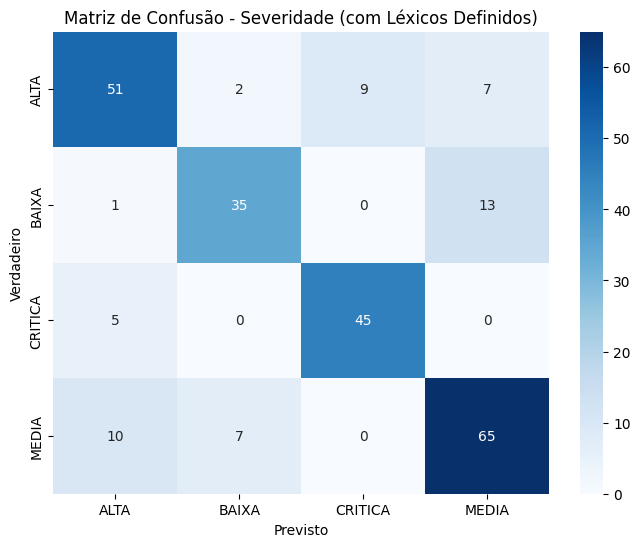

In [ ]:
cm_final = confusion_matrix(y_teste_sev_final, pred_svc_sev_final, labels=nomes_classes_severidade)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=nomes_classes_severidade, yticklabels=nomes_classes_severidade)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Severidade (com Léxicos Definidos)')
plt.show()

Bom, as features de não trouxeram uma revolução no desempenho geral, mas causaram uma redistribuição de como o modelo acerta e erra entre as classes, a acurácia geral não mudou, e o F1-score macro melhorou minimamente

* A categoria MEDIA foi a que mais se beneficiou, o F1-score foi de 0.71 para 0.76, mantendo o recall, o que é um bom sinal de que as palavras do léxico MEDIA ajudaram o modelo a ser mais confiante e correto quando prevê essa categoria
* BAIXA: Teve um leve aumento no F1-score. O recall aumentou (de 0.65 para 0.71), significando que mais casos BAIXA foram corretamente identificados, embora a precisão tenha caído um pouco (de 0.84 para 0.80)
* Porém isso veio ao custo de um tradeoff em CRITICA, o F1-score permaneceu o mesmo (0.87). Mas a precisão caiu (de 0.89 para 0.83) e o recall aumentou (de 0.84 para 0.90). Isso significa que o modelo com os léxicos identifica mais corretamente os casos que são realmente CRITICA (cerca de 90%), o que é muito positivo para uma classe dessa importancia. Mas ele também classifica errado  alguns casos de outras severidades como CRITICA com mais frequência (nesse caso eu acho que vale a pena a troca já que estamos minimizando os falsos negativos, esse aumento no recall é importante, mesmo com uma pequena perda de precisão).
* A categoria ALTA piorou no geral, já que o modelo ficou mais criterioso

Como a troca de precisão por recall para a categoria CRITICA, não representa realmente um problema, vamos analisar as categorias no "meio" onde o modelo está se perdendo mais ALTA x MEDIA e MEDIA x BAIXA

In [ ]:
# Criando um data frame separado pra ver os erros
df_analise_erros = pd.DataFrame({
  'y_verdadeiro': y_teste_sev_final,
  'y_previsto': pred_svc_sev_final
})

In [ ]:
# Adicionar o texto original e o texto processado
df_analise_erros['texto_original_raw'] = df_alertas.loc[df_analise_erros.index, 'descricaoTexto']
df_analise_erros['texto_processado'] = df_copy.loc[df_analise_erros.index, 'descricaoTexto']

df_analise_erros['lex_count_alta'] = df_copy.loc[df_analise_erros.index, 'lex_count_alta']
df_analise_erros['lex_count_media'] = df_copy.loc[df_analise_erros.index, 'lex_count_media']
df_analise_erros['lex_count_baixa'] = df_copy.loc[df_analise_erros.index, 'lex_count_baixa']

Analisando cada caso:

In [ ]:
def imprimir_detalhes_erro(casos_de_erro, lexico_verdadeiro_nome, lexico_verdadeiro_lista, lexico_previsto_nome, lexico_previsto_lista):
  if casos_de_erro.empty:
    print("Nenhum caso encontrado para este tipo de erro.")
    return

  for index, row in casos_de_erro.iterrows():
    print(f"\nRelato Índice Original: {index}")
    print(f"  Texto Original Raw: {row['texto_original_raw']}")
    print(f"  Texto Processado:   {row['texto_processado']}")
    print(f"  Contagem Lex. {lexico_verdadeiro_nome.upper()}: {row[f'lex_count_{lexico_verdadeiro_nome}']}")
    print(f"  Contagem Lex. {lexico_previsto_nome.upper()}:    {row[f'lex_count_{lexico_previsto_nome}']}")

    palavras_lex_verdadeiro_presentes = [p for p in lexico_verdadeiro_lista if p in row['texto_processado'].split()]
    palavras_lex_previsto_presentes = [p for p in lexico_previsto_lista if p in row['texto_processado'].split()]

    print(f"  Palavras de lexico_{lexico_verdadeiro_nome}_recente presentes: {palavras_lex_verdadeiro_presentes if palavras_lex_verdadeiro_presentes else 'Nenhuma'}")
    print(f"  Palavras de lexico_{lexico_previsto_nome}_recente presentes:    {palavras_lex_previsto_presentes if palavras_lex_previsto_presentes else 'Nenhuma'}")
    print("-" * 40)

In [ ]:
print("Análise de Erros: Casos Verdadeiros 'BAIXA' classificados como 'MEDIA'")
erros_baixa_para_media = df_analise_erros[
  (df_analise_erros['y_verdadeiro'] == 'BAIXA') &
  (df_analise_erros['y_previsto'] == 'MEDIA')
]
print(f"Total de {len(erros_baixa_para_media)} casos.")
imprimir_detalhes_erro(erros_baixa_para_media, 'baixa', lexico_baixa_v1, 'media', lexico_media_v1)

Análise de Erros: Casos Verdadeiros 'BAIXA' classificados como 'MEDIA'
Total de 13 casos.

Relato Índice Original: 890
  Texto Original Raw: Água acumulada em via pública na altura do número 200 da Avenida Paulista. Solo com drenagem limitada, mas sem impacto significativo nas estruturas circundantes. Tráfego fluindo com lentidão, requerendo atenção moderada dos motoristas.
  Texto Processado:   agu acumul via publ altur numer 200 aven paul sol dren limit impact signific estrut circund trafeg flu lentida requer atenca moder motor
  Contagem Lex. BAIXA: 0
  Contagem Lex. MEDIA:    3
  Palavras de lexico_baixa_recente presentes: Nenhuma
  Palavras de lexico_media_recente presentes:    ['acumul', 'atenca', 'moder']
----------------------------------------

Relato Índice Original: 101
  Texto Original Raw: Notamos um poste de luz com fios expostos na esquina da Rua dos Pinheiros. Cuidado ao passar por lá!
  Texto Processado:   not post luz fio expost esquin rua pinh cuid pass la
  Contagem

In [ ]:
print("Análise de Erros: Casos Verdadeiros 'MEDIA' classificados como 'ALTA'")
erros_media_para_alta = df_analise_erros[
  (df_analise_erros['y_verdadeiro'] == 'MEDIA') &
  (df_analise_erros['y_previsto'] == 'ALTA')
]
print(f"Total de {len(erros_media_para_alta)} casos.")
imprimir_detalhes_erro(erros_media_para_alta, 'media', lexico_media_v1, 'alta', lexico_alta_v1)

Análise de Erros: Casos Verdadeiros 'MEDIA' classificados como 'ALTA'
Total de 10 casos.

Relato Índice Original: 269
  Texto Original Raw: Ocorreu um deslizamento na Rua das Flores, nas proximidades do número 123, por volta das 15h. Não há feridos e a via está parcialmente bloqueada. Autoridades já foram acionadas para controlar a situação.
  Texto Processado:   ocorr desliz rua fl proxim numer 123 volt 15h nao ha fer via parc bloque autoridad ja acion control situaca
  Contagem Lex. MEDIA: 2
  Contagem Lex. ALTA:    0
  Palavras de lexico_media_recente presentes: ['parc', 'situaca']
  Palavras de lexico_alta_recente presentes:    Nenhuma
----------------------------------------

Relato Índice Original: 14
  Texto Original Raw: Alagamento registrado na Avenida Paulista, altura do número 1500, causado por chuvas intensas. Áreas de passeio e faixas de rolamento afetadas, com escoamento parcial da água. Necessidade de atenção ao transitar, mas situação controlada sem risco imediato.
  Te

Conclusão da análise:
* acumul (do lexico_media_v1) é tem uma grande parcela de culpa, ele aparece em 7/13 erros. Geralmente, o texto original de BAIXA menciona "água acumulada" mas com junto com "sem impacto significativo", "sem grandes problemas", "alagamento superficial", "controlando a situação". O léxico pega o "acumul" mas o modelo não dá peso suficiente pros qualificadores de BAIXA
* O problema principal parece ser no refinamento dos léxicos no geral

#### Segundo teste

In [ ]:
# Construindo os novos léxicos garantindo que os radicais estão corretos
palavras_propostas = {
  "ALTA_v2": [
    'instável', 'instabilidade', 'intenso', 'intensa', 'perigo', 'perigoso', 'grave',
    'alerta', 'elevado', 'elevada', 'risco', 'severo', 'inundado', 'inundando', 'inundação',
    'transbordando', 'transbordou', 'agravando', 'significativo', 'interditado', 'interdição',
    'desocupar','rompimento', 'avançando', 'rápido', 'subindo', 'piorar'
  ],
  "MEDIA_v2": [
    'acumulação', 'parcial', 'atenção', 'atento', 'moderado', 'localizado', 'observação',
    'escoamento', 'movimentação de terra', 'cedendo', 'fumaça', 'denso', 'sinais', 'galhos quebrados',
    'galho pendendo', 'inclinada', 'inclinando', 'obstrução', 'obstruído', 'lentidão', 'precaução',
    'desvio', 'erosão', 'deslizamento pequeno'
  ],
  "BAIXA_v2": [
    'pequeno', 'pequena', 'leve', 'não', 'cuidado', 'monitorar', 'monitoramento',
    'controle', 'controlado', 'sob controle', 'sem danos', 'sem risco', 'sem gravidade',
    'resolvido', 'normalizado', 'isolado', 'preventivo', 'prevenção', 'recomendação',
    'apenas', 'ligeiro', 'nenhum perigo', 'superficial', 'eficientemente'
  ]
}

radicais_verificados = {}

for nome_lexico, lista_de_palavras in palavras_propostas.items():
  print(f"\n--- {nome_lexico} ---")
  radicais_unicos = set()
  for palavra in lista_de_palavras:
    radical = stemmer_pt.stem(palavra)
    print(f"  '{palavra}' -> '{radical}'")
    radicais_unicos.add(radical)
  radicais_verificados[nome_lexico] = sorted(list(radicais_unicos))

for nome_lexico, lista_radicais in radicais_verificados.items():
    print(f"lexico_{nome_lexico.lower()} = {lista_radicais}")


--- ALTA_v2 ---
  'instável' -> 'inst'
  'instabilidade' -> 'instabil'
  'intenso' -> 'intens'
  'intensa' -> 'intens'
  'perigo' -> 'perig'
  'perigoso' -> 'perig'
  'grave' -> 'grav'
  'alerta' -> 'alert'
  'elevado' -> 'elev'
  'elevada' -> 'elev'
  'risco' -> 'risc'
  'severo' -> 'sever'
  'inundado' -> 'inund'
  'inundando' -> 'inund'
  'inundação' -> 'inund'
  'transbordando' -> 'transbord'
  'transbordou' -> 'transbord'
  'agravando' -> 'agrav'
  'significativo' -> 'signific'
  'interditado' -> 'interdit'
  'interdição' -> 'interd'
  'desocupar' -> 'desocup'
  'rompimento' -> 'romp'
  'avançando' -> 'avanç'
  'rápido' -> 'rápid'
  'subindo' -> 'sub'
  'piorar' -> 'pior'

--- MEDIA_v2 ---
  'acumulação' -> 'acumul'
  'parcial' -> 'parc'
  'atenção' -> 'atenç'
  'atento' -> 'atent'
  'moderado' -> 'moder'
  'localizado' -> 'local'
  'observação' -> 'observ'
  'escoamento' -> 'esco'
  'movimentação de terra' -> 'movimentação de terr'
  'cedendo' -> 'ced'
  'fumaça' -> 'fumaç'
  'd

In [ ]:
lexico_critica_v2 = lexico_critica_v1
lexico_alta_v2 = ['agrav', 'alert', 'avanç', 'desocup', 'elev', 'grav', 'inst', 'instabil', 'intens', 'interd', 'interdit', 'inund', 'perig', 'pior', 'risc', 'romp', 'rápid', 'sever', 'signific', 'sub', 'transbord']
lexico_media_v2 = ['acumul', 'atent', 'atenç', 'ced', 'dens', 'deslizamento pequen', 'desvi', 'eros', 'esco', 'fumaç', 'galho pend', 'galhos quebr', 'inclin', 'lent', 'local', 'moder', 'movimentação de terr', 'observ', 'obstru', 'obstruç', 'parc', 'precauç', 'sinal']
lexico_baixa_v2 = ['apen', 'control', 'cuid', 'efici', 'isol', 'lev', 'lig', 'monitor', 'nenhum perig', 'norm', 'não', 'pequen', 'preven', 'prevenç', 'recomend', 'resolv', 'sem d', 'sem grav', 'sem risc', 'sob control', 'superfic']

In [ ]:
lexicos_v2 = {
  'critica': lexico_critica_v2,
  'alta': lexico_alta_v2,
  'media': lexico_media_v2,
  'baixa': lexico_baixa_v2
}

In [ ]:
for nome_lexico, lista_palavras in lexicos_v2.items():
  df_copy[f'lex_count_{nome_lexico}'] = X_processado.apply(
    lambda texto: contar_palavras_lexico(texto, lista_palavras)
  )

In [ ]:
colunas_lexico_v2 = [f'lex_count_{nome_lexico}' for nome_lexico in lexicos_v2.keys()]
print("Primeiras linhas das features de contagem de léxico:")
print(df_copy[colunas_lexico_v2].head())

Primeiras linhas das features de contagem de léxico:
   lex_count_critica  lex_count_alta  lex_count_media  lex_count_baixa
0                  0               0                1                0
1                  0               0                1                1
2                  3               0                0                0
3                  1               0                1                0
4                  2               1                0                2


In [ ]:
# Mantendo os parametros do vetorizador original
vetorizador_tfidf_v2 = TfidfVectorizer(
  ngram_range=(1, 2),
  max_df=0.95,
  min_df=2,
  sublinear_tf=True
)
X_tfidf_componente_v2 = vetorizador_tfidf_v2.fit_transform(X_processado)

In [ ]:
features_lexico_numericas_v2 = df_copy[colunas_lexico_v2].values
X_combinado_v2 = hstack([X_tfidf_componente_v2, csr_matrix(features_lexico_numericas_v2)])

print(f"\nShape da matriz TF-IDF: {X_tfidf_componente_v2.shape}")
print(f"Shape das features de léxico: {features_lexico_numericas_v2.shape}")
print(f"Shape da matriz combinada: {X_combinado_v2.shape}")


Shape da matriz TF-IDF: (1000, 2793)
Shape das features de léxico: (1000, 4)
Shape da matriz combinada: (1000, 2797)


In [ ]:
X_treino_v2, X_teste_v2, y_treino_v2, y_teste_v2 = train_test_split(
  X_combinado_v2, y_severidade, test_size=0.25, random_state=42, stratify=y_severidade
)

In [ ]:
modelo_svc_v2 = LinearSVC(random_state=42, dual="auto", max_iter=2000)
modelo_svc_v2.fit(X_treino_v2, y_treino_v2)
pred_svc_v2 = modelo_svc_v2.predict(X_teste_v2)


Resultados LinearSVC (Severidade com Léxicos v2):
              precision    recall  f1-score   support

        ALTA       0.79      0.77      0.78        69
       BAIXA       0.80      0.67      0.73        49
     CRITICA       0.85      0.92      0.88        50
       MEDIA       0.75      0.80      0.78        82

    accuracy                           0.79       250
   macro avg       0.80      0.79      0.79       250
weighted avg       0.79      0.79      0.79       250


Matriz de Confusão (Severidade com Léxicos v2):


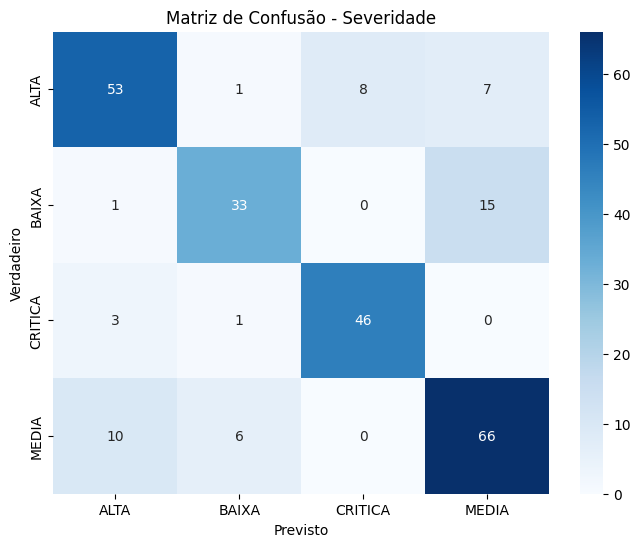

In [ ]:
print("\nResultados LinearSVC (Severidade com Léxicos v2):")
nomes_classes_severidade = sorted(y_severidade.unique())
print(classification_report(y_teste_v2, pred_svc_v2, labels=nomes_classes_severidade, target_names=nomes_classes_severidade))

print("\nMatriz de Confusão (Severidade com Léxicos v2):")
cm_final_atualizado = confusion_matrix(y_teste_v2, pred_svc_v2, labels=nomes_classes_severidade)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final_atualizado, annot=True, fmt='d', cmap='Blues', xticklabels=nomes_classes_severidade, yticklabels=nomes_classes_severidade)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Severidade')
plt.show()

O resoltado do segundo teste são os melhores até agora qualitativamente falando, eles mantiveram a acurácia geral alta (até aumentou um pouco), mas também melhoraram significativamente o recall da classe CRITICA para excelentes 92%, e melhoraram o F1-score de ALTA e MEDIA. A pequena queda em BAIXA é um tradeoff aceitável que são justificados pelos ganhos nas classes de maior importancia, essas métricas justificam passar para o hyperparameter tuning

## Hyperparameter Tuning

O hyperparameter tuning ajuda a encontrar automaticamente a melhor combinação de configurações dos parametros de treinamento para o modelo de LinearSVC para maximizar o desempenho.

Após o processo de engenharia de features com a criação e refinamento dos nossos léxicos, o LinearSVC (com lexicos_v2) para o modelo de SEVERIDADE apresentou os resultados mais promissores e qualitativamente satisfatórios. Para tentar extrair o máximo de desempenho deste modelo, procedemos com o ajuste de hiperparâmetros. (lembrando que não houve necessidade do refinamento dos parâmetros para o modelo de TIPO)

### Modelo de SEVERIDADE

Para o modelo LinearSVC de severidade (após MUITO sofrimento kkk), tentei ajustar os seguintes hiperparâmetros:

* C: Parâmetro de regularização. Valores menores especificam regularização mais forte (modelo mais simples, menos propenso a overfitting), enquanto valores maiores indicam regularização mais fraca (modelo mais complexo, pode se ajustar demais aos dados de treino).
* penalty: Especifica a norma usada na penalização (regularização). 'l1' pode levar a esparsidade nos coeficientes (feature selection), enquanto 'l2' é a penalização padrão.
* class_weight: Permite atribuir pesos diferentes às classes. Útil quando há desbalanceamento de classes ou quando errar uma classe é mais custoso que errar outra. None significa que todas as classes têm peso 1, enquanto 'balanced' ajusta os pesos inversamente proporcionais às frequências das classes.


Utilizamos a técnica GridSearchCV do Scikit-learn, que testa todas as combinações de hiperparâmetros fornecidas em um "grid" e, através de validação cruzada (cv=5), seleciona a combinação que maximiza uma métrica de desempenho especificada (neste caso, f1_macro)

In [ ]:
base_model_svc_tuning = LinearSVC(random_state=42, loss='squared_hinge', dual=False, max_iter=5000)

In [ ]:
param_grid_svc_tuning = {
  'C': [0.05, 0.1, 0.25, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0, 5.0],
  'penalty': ['l1', 'l2'],
  'class_weight': [None, 'balanced']
}

In [ ]:
print("\nIniciando GridSearchCV para LinearSVC...")
grid_search_svc_tuning = GridSearchCV(estimator=base_model_svc_tuning,
                               param_grid=param_grid_svc_tuning,
                               scoring='f1_macro',
                               cv=5,
                               verbose=2,
                               n_jobs=-1)

grid_search_svc_tuning.fit(X_treino_v2, y_treino_v2)

print("\nMelhores parâmetros encontrados pelo GridSearchCV:")
print(grid_search_svc_tuning.best_params_)
print(f"Melhor score F1-Macro (validação cruzada): {grid_search_svc_tuning.best_score_:.4f}")


Iniciando GridSearchCV para LinearSVC...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Melhores parâmetros encontrados pelo GridSearchCV:
{'C': 0.8, 'class_weight': 'balanced', 'penalty': 'l2'}
Melhor score F1-Macro (validação cruzada): 0.7725


In [ ]:
best_svc_model_tuning = grid_search_svc_tuning.best_estimator_
pred_best_svc = best_svc_model_tuning.predict(X_teste_v2)


Resultados do Melhor Modelo LinearSVC (após GridSearchCV) no Conjunto de Teste:
              precision    recall  f1-score   support

        ALTA       0.78      0.77      0.77        69
       BAIXA       0.80      0.71      0.75        49
     CRITICA       0.84      0.92      0.88        50
       MEDIA       0.76      0.77      0.76        82

    accuracy                           0.79       250
   macro avg       0.79      0.79      0.79       250
weighted avg       0.79      0.79      0.79       250


Matriz de Confusão do Melhor Modelo LinearSVC no Conjunto de Teste:


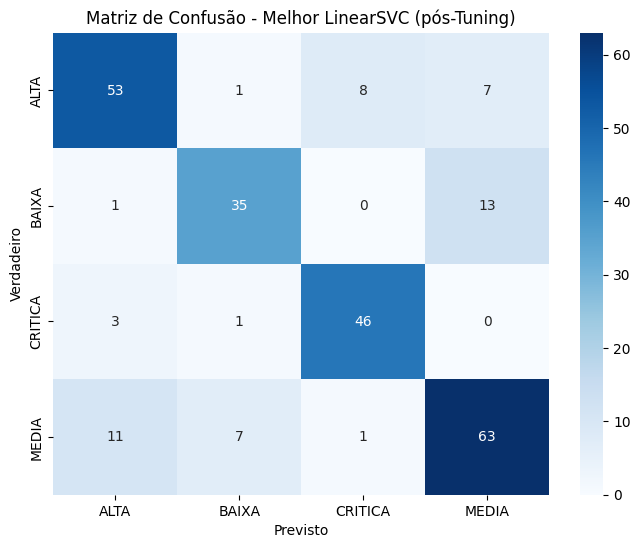

In [ ]:
print("\nResultados do Melhor Modelo LinearSVC (após GridSearchCV) no Conjunto de Teste:")
nomes_classes_severidade = sorted(y_severidade.unique())
print(classification_report(y_teste_v2, pred_best_svc, labels=nomes_classes_severidade, target_names=nomes_classes_severidade))

print("\nMatriz de Confusão do Melhor Modelo LinearSVC no Conjunto de Teste:")
cm_best_svc = confusion_matrix(y_teste_v2, pred_best_svc, labels=nomes_classes_severidade)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_svc, annot=True, fmt='d', cmap='Blues', xticklabels=nomes_classes_severidade, yticklabels=nomes_classes_severidade)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Melhor LinearSVC (pós-Tuning)')
plt.show()

Em uma primeira olhada da pra ter a impressão de que o modelo ficou ligeiramente pior, mas analisando bem, eu creio que melhorou significativamente para um POC do aplicativo, se tratou de uma questão de trade-offs assim como no treinamento com os léxicos:
* CRITICA (mais segura): O F1-score se manteve em 0.88, mas o recall continua excelente em 0.92 (46 acertos em 50). Melhora importante: O número de casos CRITICA classificados erroneamente como ALTA caiu de 5 para 3. Esse era um dos erros mais preocupantes, já que uma misdiagnosis de uma situação crítica pode ser catastrófico, então isso é um ganho de segurança
* ALTA (melhorou ligeiramente na prática): Apesar do F1-score ter caído um pouco (0.78 para 0.77), a matriz mostra que o modelo acertou mais casos ALTA (53 vs 51) e errou menos para CRITICA e BAIXA. A queda no F1 provavelmente deve ser por causa da mudança no equilíbrio entre precisão e recall (Precisão: 0.79 -> 0.78, Recall: 0.77 -> 0.77)
* BAIXA (melhorou): O F1-score subiu de 0.73 para 0.75, por causa do aumento no recall (de 0.67 para 0.71, ou seja, 35 acertos em 49, antes eram ~33)
* MEDIA (leve piora): Foi a classe que ficou pra Cristo, F1 caiu de 0.78 para 0.76, principalmente por causa da queda no recall (de 0.80 para 0.77, ou seja, 63 acertos em 82, antes eram 65). Aumentou a confusão com ALTA, porém um diagnóstico errado para uma classe de perigo mais baixa não é um ponto tão critico quanto a precisão do diagnóstico para situações de risco ALTO e CRITICO

Creio que esse é o fim do processo de otimização dessa pipeline

## Salvando os modelos

In [ ]:
models_save_path = os.path.join(project_base_path, 'Trained_Models')

In [ ]:
print("Salvando componentes do modelo de TIPO...")
path_vetorizador_tipo_final = os.path.join(models_save_path, 'vetorizador_tfidf_TIPO_final.joblib')
joblib.dump(vetorizador_tfidf, path_vetorizador_tipo_final)
print(f"Vetorizador TF-IDF para TIPO salvo em: {path_vetorizador_tipo_final}")

path_modelo_tipo_final = os.path.join(models_save_path, 'modelo_svc_TIPO_final.joblib')
joblib.dump(modelo_svc_tipo, path_modelo_tipo_final)
print(f"Modelo de TIPO salvo em: {path_modelo_tipo_final}")


print("\nSalvando componentes do modelo de SEVERIDADE...")
path_vetorizador_severidade_final = os.path.join(models_save_path, 'vetorizador_tfidf_SEVERIDADE_final.joblib')
joblib.dump(vetorizador_tfidf_v2, path_vetorizador_severidade_final)
print(f"Vetorizador TF-IDF para SEVERIDADE salvo em: {path_vetorizador_severidade_final}")

path_modelo_severidade_final = os.path.join(models_save_path, 'modelo_svc_SEVERIDADE_tuned_final.joblib')
joblib.dump(best_svc_model_tuning, path_modelo_severidade_final)
print(f"Modelo de SEVERIDADE (tuned) salvo em: {path_modelo_severidade_final}")

print("\n--- Lembretes para a Aplicação ---")
print("1. As seguintes listas de léxicos (radicais) foram usadas para o modelo de SEVERIDADE e precisarão ser definidas na sua aplicação:")
print(f"   lexico_critica_v2 = {lexico_critica_v2}")
print(f"   lexico_alta_v2 = {lexico_alta_v2}")
print(f"   lexico_media_v2 = {lexico_media_v2}")
print(f"   lexico_baixa_v2 = {lexico_baixa_v2}")
print("2. As funções 'preprocessar_texto' e 'contar_palavras_lexico' também serão necessárias.")
print("3. O stemmer 'stemmer_pt' (RSLPStemmer) e as 'stop_words_pt' do NLTK precisarão ser inicializados.")


Salvando componentes do modelo de TIPO...
Vetorizador TF-IDF para TIPO salvo em: /content/drive/MyDrive/Colab_Notebooks/AlertaVermelho_AI/Trained_Models/vetorizador_tfidf_TIPO_final.joblib
Modelo de TIPO salvo em: /content/drive/MyDrive/Colab_Notebooks/AlertaVermelho_AI/Trained_Models/modelo_svc_TIPO_final.joblib

Salvando componentes do modelo de SEVERIDADE...
Vetorizador TF-IDF para SEVERIDADE salvo em: /content/drive/MyDrive/Colab_Notebooks/AlertaVermelho_AI/Trained_Models/vetorizador_tfidf_SEVERIDADE_final.joblib
Modelo de SEVERIDADE (tuned) salvo em: /content/drive/MyDrive/Colab_Notebooks/AlertaVermelho_AI/Trained_Models/modelo_svc_SEVERIDADE_tuned_final.joblib

--- Lembretes para a Aplicação ---
1. As seguintes listas de léxicos (radicais) foram usadas para o modelo de SEVERIDADE e precisarão ser definidas na sua aplicação:
   lexico_critica_v2 = ['crit', 'imediat', 'seguranc', 'cas', 'colaps', 'destru', 'evacu', 'urgent', 'emergenc', 'bloqu', 'bloque', 'caiu', 'ocorr', 'acontec'